# 2023/24 - LSTM

This notebook is a implementation of a **LSTM** for Driving Behavior Classification. The model is trained on the [IPL-Dataset](http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/) dataset. 

The dataset contains recorded driving scenarios like Intersections, Acceleration, Brake. The dataset is divided into 3 classes: **Slow, Normal and Aggressive**.

Each driving scenario is represented by a sequence of sensor data. The sensor data is collected from the following sensors:
- Accelerometer
- Gyroscope
- GPS


## Libraries

## Directories

In [14]:
import os

# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))

datasets_dir = os.path.join(root_dir, 'datasets')

dataset_dir = os.path.join(datasets_dir, 'IPL-Dataset')


print(f'Root directory: {root_dir}')
print(f'Datasets directory: {datasets_dir}')
print(f'Dataset directory: {dataset_dir}')

Root directory: c:\codeUni\ProjetoInformatico\FinalProject-AI-DrivingClassification
Datasets directory: c:\codeUni\ProjetoInformatico\FinalProject-AI-DrivingClassification\datasets
Dataset directory: c:\codeUni\ProjetoInformatico\FinalProject-AI-DrivingClassification\datasets\IPL-Dataset


# **Data Preprocessing**

## Data structure:
- Acceleration (m/s2): X, Y, Z Axis 

- Gyroscope (°/s): X, Y, Z Axis

- GPS: Latitude and Longitude 

## Load dataset and apply rolling window

In [15]:
import json
import pandas as pd
import numpy as np

def apply_rolling_window(df):
    """
    Apply a centered rolling mean with a window of 3 to each column of the DataFrame.
    For each value, the function computes the mean of the value itself, the one before, and the one after.
    """
    df = df.rolling(window=3, center=True, min_periods=1).mean()    
    
    return df

directories = ['Acceleration', 'Brake', 'Intersection']
column_names = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'Latitude', 'Longitude']

data_bmw = pd.DataFrame(columns=column_names)
labels_bmw = []
data_honda = pd.DataFrame(columns=column_names)
labels_honda = []

label_names = []


# TODO Import other folders too

for directory in directories:
    for root, dirs, files in os.walk(os.path.join(dataset_dir, directory)):
        if 'turn 90 degree constant speed' in root: # Skip this directory
            continue
        for file in files:
            if file.endswith('.json'):
                car = os.path.basename(root).split()[0].upper()            
                label = os.path.basename(os.path.dirname(root))
                # print(f'Processing: {car} : {label} : {directory} : {file}')
                
                file_data = json.load(open(os.path.join(root, file)))
                file_data = file_data['capturedData']
                file_data = pd.DataFrame(file_data)
                
                # Rename speed Km/h to speed
                file_data.rename(columns={'speed Km/h': 'speed'}, inplace=True)
                file_data.rename(columns={'speedKmh': 'speed'}, inplace=True)
                
                file_data.drop(['speed'], axis=1, inplace=True, errors='ignore')
                
                 # Drop timestamp
                file_data = file_data.drop(['createdAt'], axis=1, errors='ignore')
                file_data = file_data.drop(['timestamp'], axis=1, errors='ignore')   
                file_data = file_data.drop(['id'], axis=1, errors='ignore')
                
                # Apply rolling window
                file_data_rolling = apply_rolling_window(file_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']])
                
                file_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']] = file_data_rolling
    
                labels = np.full((file_data.shape[0], 1), label)
                
                column_names = file_data.columns
                # print(f'Column names: {column_names}')
                
                # If data is empty, create a new dataframe with the column names
                if data_bmw.empty:
                    data_bmw = pd.DataFrame(columns=column_names)
                    # print(f'Data BMW shape: {data_bmw.shape}')
                if data_honda.empty:
                    data_honda = pd.DataFrame(columns=column_names)
                    # print(f'Data HONDA shape: {data_honda.shape}')
                
                if car == 'BMW':                                      
                    data_bmw = pd.concat([data_bmw, file_data.copy()], axis=0)
                    # print(f'Data BMW shape: {data_bmw.shape}')
                    
                    labels_bmw += labels.tolist()
                    # print(f'Labels BMW shape: {len(labels_bmw)}')
                    
                elif car == 'HONDA':
                    data_honda = pd.concat([data_honda, file_data.copy()], axis=0)
                    # print(f'Data HONDA shape: {data_honda.shape}')
                    
                    labels_honda += labels.tolist()
                    # print(f'Labels HONDA shape: {len(labels_honda)}')
                    
# Show data shapes      
print(f'BMW Data shape: {data_bmw.shape}')
print(f'BMW Labels shape: {len(labels_bmw)}')
print(f'Honda Data shape: {data_honda.shape}')
print(f'Honda Labels shape: {len(labels_honda)}')

# Show unique labels
print(f'BMW Labels: {np.unique(labels_bmw)}')
print(f'Honda Labels: {np.unique(labels_honda)}')
label_names = np.unique(labels_bmw)

# Save Data to CSV - runtime_saves folder
data_bmw.to_csv('runtime_saves/bmw_data.csv', index=False)
data_honda.to_csv('runtime_saves/honda_data.csv', index=False)
labels_bmw = np.array(labels_bmw)
labels_honda = np.array(labels_honda)

# Save Labels to CSV - runtime_saves folder
np.savetxt('runtime_saves/bmw_labels.csv', labels_bmw, delimiter=',', fmt='%s')
np.savetxt('runtime_saves/honda_labels.csv', labels_honda, delimiter=',', fmt='%s')

C:\Users\PDesktop\AppData\Local\Temp\ipykernel_10392\1933527817.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_bmw = pd.concat([data_bmw, file_data.copy()], axis=0)
C:\Users\PDesktop\AppData\Local\Temp\ipykernel_10392\1933527817.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_honda = pd.concat([data_honda, file_data.copy()], axis=0)


BMW Data shape: (3001, 8)
BMW Labels shape: 3001
Honda Data shape: (1081, 8)
Honda Labels shape: 1081
BMW Labels: ['aggressive' 'normal' 'slow']
Honda Labels: ['aggressive' 'normal' 'slow']


In [16]:
import numpy as np
import pandas as pd

# Load the dataset into a DataFrame
df_bmw = pd.read_csv('runtime_saves/bmw_data.csv')
df_honda = pd.read_csv('runtime_saves/honda_data.csv')

# Load the labels into a NumPy array
labels_bmw = np.loadtxt('runtime_saves/bmw_labels.csv', delimiter=',', dtype=str)
labels_honda = np.loadtxt('runtime_saves/honda_labels.csv', delimiter=',', dtype=str)

labels = np.concatenate([labels_bmw, labels_honda], axis=0)

## Show Labels

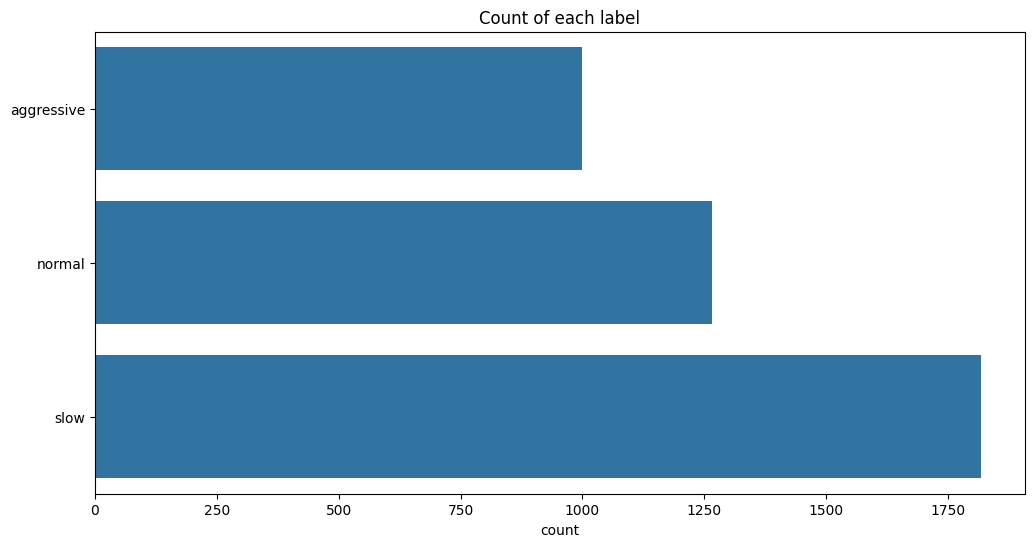

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = pd.Series(labels)

# plot the count of each label
plt.figure(figsize=(12, 6))
sns.countplot(labels)
plt.title('Count of each label')
plt.show()

## Label Encoding

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)

## Normalization

In [19]:
def normalize_between_0_and_1(data, columns):
    for column in columns:
        if column not in data.columns:
            print(f"[WARNING] {column} not found in DataFrame.")
            continue
        else:
            max_value = np.max(data[column])
            min_value = np.min(data[column])
            data[column] = (data[column] - min_value) / (max_value - min_value)
    return data

columns_to_normalize = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']


df_bmw = normalize_between_0_and_1(df_bmw, columns_to_normalize)
df_honda = normalize_between_0_and_1(df_honda, columns_to_normalize)

## Concatenate Data

In [20]:
df = pd.concat([df_bmw, df_honda], axis=0)

# create label column in the dataframe
df['label'] = labels

## Create Sequences

In [21]:
import numpy as np
from scipy.stats import mode

def create_dataset(data, labels, window_size=16, step_size=2):
    X, y = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        # Create the window of data
        X.append(data[i:i + window_size].values)        
        
         # Find the most frequent string label in the current window
        window_labels = labels[i:i + window_size]
        most_frequent_label = mode(window_labels, axis=None)[0]
        
        # Add the most frequent label as the label of the current window
        y.append(most_frequent_label)
            
    return np.array(X), np.array(y)

time_steps = 16
step_size = 1

X, y = create_dataset(
    df[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis',
                   'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'Latitude', 'Longitude']],
    df['label'],
    window_size=time_steps,
    step_size=step_size    
)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# save the data to a npy
np.save('runtime_saves/X.npy', X)
np.savetxt('runtime_saves/y.csv', y, delimiter=',', fmt='%d')

X shape: (4067, 16, 8)
y shape: (4067,)


# Split Dataset for Model Training
- 70% Training
- 20% Test
- 10% Validation

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=23)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=23)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')
print(f'X_validation shape: {X_validation.shape}')
print(f'y_validation shape: {y_validation.shape}')


X_train shape: (2927, 16, 8)
y_train shape: (2927,)

X_test shape: (814, 16, 8)
y_test shape: (814,)

X_validation shape: (326, 16, 8)
y_validation shape: (326,)


In [23]:
# from tensorflow.keras import backend as K

# K.clear_session()

# **MODEL ARCHITECTURE** - Stacked LSTM

In [24]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Inputs
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = keras.Input(shape=input_shape)

# Architecture
x = LSTM(32, return_sequences=True)(inputs)
x = BatchNormalization()(x)

x = LSTM(32, return_sequences=True)(x)
x = BatchNormalization()(x)

x = LSTM(32)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(3, activation='softmax')(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 8)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 16, 32)            5248      
                                                                 
 batch_normalization_3 (Bat  (None, 16, 32)            128       
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 16, 32)            8320      
                                                                 
 batch_normalization_4 (Bat  (None, 16, 32)            128       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320

## Compile Model

In [25]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=6, 
    verbose=1, 
    factor=0.5, 
    min_lr=1e-8)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=35,
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/checkpoints/StackedLSTM-cp.h5', save_best_only=True)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint, learning_rate_reduction, early_stop])

Epoch 1/150
183/183 [==============================] - 20s 32ms/step - loss: 1.1105 - accuracy: 0.4380 - val_loss: 1.0969 - val_accuracy: 0.3098 - lr: 0.0100
Epoch 2/150
  4/183 [..............................] - ETA: 3s - loss: 1.1131 - accuracy: 0.3750

c:\Users\PDesktop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 4s 23ms/step - loss: 1.0536 - accuracy: 0.4786 - val_loss: 1.2133 - val_accuracy: 0.4356 - lr: 0.0100
Epoch 3/150
183/183 [==============================] - 5s 25ms/step - loss: 1.0603 - accuracy: 0.4496 - val_loss: 1.7418 - val_accuracy: 0.4356 - lr: 0.0100
Epoch 4/150
183/183 [==============================] - 4s 24ms/step - loss: 1.0625 - accuracy: 0.4496 - val_loss: 1.1773 - val_accuracy: 0.4356 - lr: 0.0100
Epoch 5/150
183/183 [==============================] - 5s 27ms/step - loss: 1.0450 - accuracy: 0.4739 - val_loss: 4.4595 - val_accuracy: 0.4356 - lr: 0.0100
Epoch 6/150
183/183 [==============================] - 4s 20ms/step - loss: 1.0479 - accuracy: 0.4780 - val_loss: 20.7412 - val_accuracy: 0.2546 - lr: 0.0100
Epoch 7/150
183/183 [==============================] - 4s 20ms/step - loss: 1.0439 - accuracy: 0.4783 - val_loss: 8.9767 - val_accuracy: 0.2546 - lr: 0.0100
Epoch 8/150
183/183 [==============================] - ETA: 0s - loss

In [27]:
# save model
model.save('runtime_saves/models/StackedLSTM.h5')

In [28]:
from keras.models import load_model

# Load the model
model = load_model('runtime_saves/models/StackedLSTM.h5')

# **RESULTS AND EVALUATION**

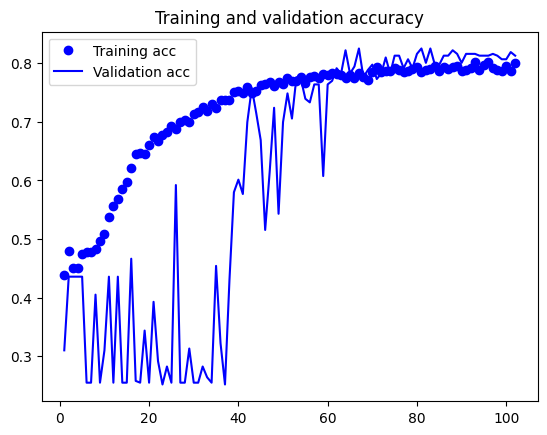

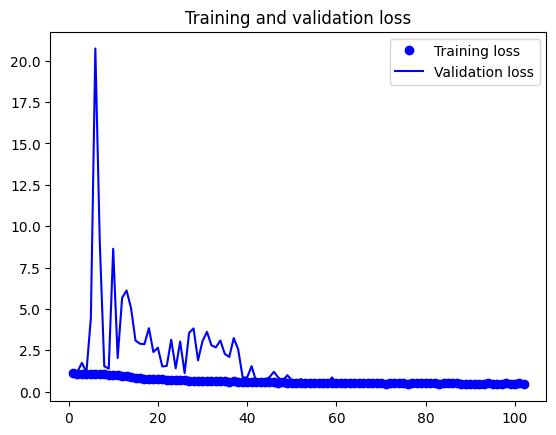

In [29]:
import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Confusion Matrix

26/26 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0
26/26 [==============================] - 2s 6ms/step
[[166  20  20]
 [ 15 158  81]
 [ 10  55 289]]


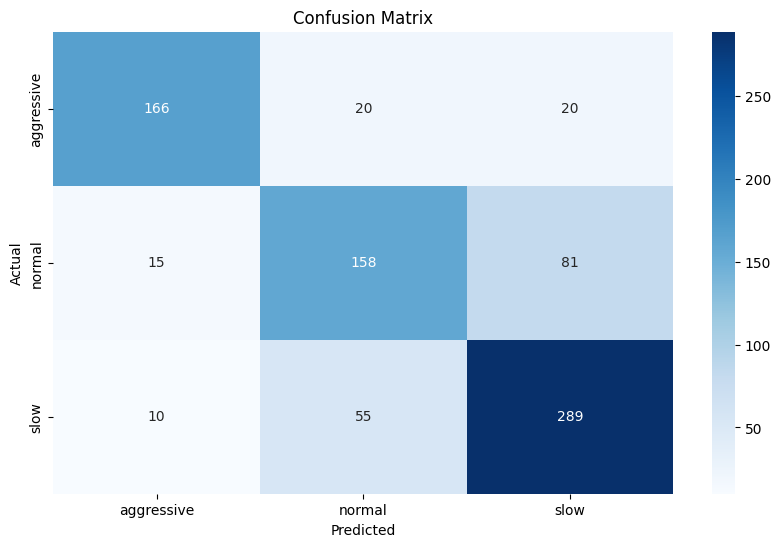

In [30]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.evaluate(X_test)
print(f'Loss: {y_pred[0]}')
print(f'Accuracy: {y_pred[1]}')

# Simple confusion matrix
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)


conf_matrix = metrics.confusion_matrix(y_test, pred)
print(conf_matrix)

# Graphical confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()























## Performance Metrics

- Accuracy  $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  
- F1 Score $\large = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$  
- Hamming Loss $\large = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Incorrect Labels}}{\text{Total Labels}}$  
- Jaccard Score $\large = \frac{|Y_{pred} \cap Y_{true}|}{|Y_{pred} \cup Y_{true}|}$  



- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculates performance metrics
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')
          
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 75.31%
Precision - Macro: 76.27%
Recall - Macro: 74.81%
F1-score - Macro: 75.4%
Precision - Weighted: 75.38%
Recall - Weighted: 75.31%
F1-score - Weighted: 75.2%
